In [2]:
using ModelingToolkit
using OrdinaryDiffEq
using DifferentialEquations
using AlgebraicPetri
using AlgebraicPetri.Epidemiology
using AlgebraicPetri.BilayerNetworks

using Catlab
using Catlab.CategoricalAlgebra
using Catlab.Graphics
import Catlab.CategoricalAlgebra: migrate!
using Catlab.WiringDiagrams
using Catlab.Programs.RelationalPrograms

using JSON

In [3]:
make_depvar(p,t) = :($p($t))

make_depvar (generic function with 1 method)

In [4]:
function compile(bn::Union{AbstractLabelledBilayerNetwork, AbstractBilayerNetwork})
  varstmt = :(@variables t)
  varnames = bn[:variable]
  append!(varstmt.args, make_depvar.(bn[:variable], :t))

  paramstmt = :(@parameters)
  params = bn[:parameter]
  append!(paramstmt.args, bn[:parameter])

  diffstmt = :(D = Differential(t))

  ϕs = map(parts(bn, :Box)) do b
    vars = map(incident(bn, b,:call)) do i
      j = bn[i, :arg]
      return bn[j, :variable]
    end
    p = :(*($(bn[b, :parameter])))
    append!(p.args, vars)
    return :($(Symbol("ϕ$b")) = $p)
  end

  infs = map(parts(bn, :Qout)) do tv
    vars = map(incident(bn, tv, :infusion)) do wa
      j = bn[wa, :influx]
      return Symbol("ϕ$j")
    end
    p = :(+())
    append!(p.args, vars)

    # same for the outfluxes
    vars = map(incident(bn, tv, :effusion)) do wn
      j = bn[wn, :efflux]
      return :(- $(Symbol("ϕ$j")))
    end
    append!(p.args, vars)
    return p
  end

  zparts = zip(bn[:tanvar], infs)

  eqns = [:(D($tanvar) ~ $rhs) for (tanvar, rhs) in zparts]
  eq = :([])
  append!(eq.args, eqns)
  eqnstmt = :(eqs = $eq)

  varnameexpr = Expr(:tuple, varnames...)
  parnameexpr = Expr(:tuple, params...)

  return quote
    $varstmt
    $paramstmt
    $diffstmt
    $(ϕs...)
    $eqnstmt
    return $varnameexpr, $parnameexpr, ODESystem(eqs, t, name=:PetriNet)
  end
end

compile (generic function with 1 method)

In [6]:
@present TheoryOrigMIRANet <: SchLabelledReactionNet begin
    MID::AttrType
    MCTX::AttrType
    Template::AttrType
    mira_ids::Attr(S, MID)
    mira_context::Attr(S, MCTX)
    template_type::Attr(T, Template)
    parameter_name::Attr(T, Name)
    parameter_value::Attr(T, Rate)
end
@abstract_acset_type AbstractOrigMIRANet <: AbstractLabelledReactionNet
@acset_type OrigMIRANet(TheoryOrigMIRANet) <: AbstractOrigMIRANet

OrigMIRANet

In [23]:
function mtk_simulate(jsonfile, states, params, timespan)
    mira = read_json_acset(OrigMIRANet{Any,Any,Any,Any,Any,Any}, jsonfile)
    map!(Symbol, mira[:sname], mira[:sname])
    map!(Symbol, mira[:tname], mira[:tname])
    bnsir = LabelledBilayerNetwork()
    migrate!(bnsir, LabelledPetriNet(mira))
    mdl = eval(compile(bnsir))
    prob = ODEProblem(mdl[3], states, timespan, params)
    soln = solve(prob)
    plot(soln)
    # json(Dict(:time=>soln.t, :states=>soln.u))
end

mtk_simulate (generic function with 1 method)

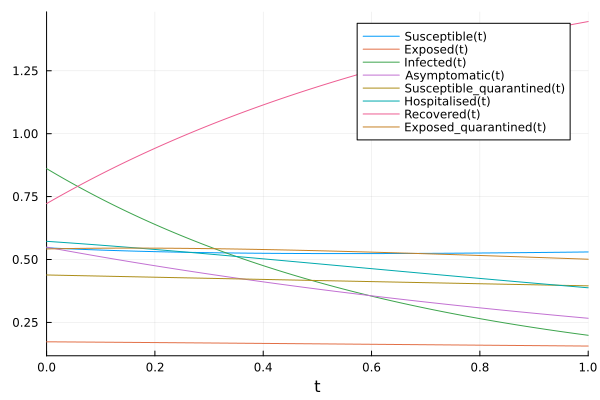

In [25]:
mtk_simulate("jeff-petri.json", rand(8), rand(13), (0, 1))

String